#### Second model : extract departure and arrival cities (NER)

##### Imports

In [1]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import random

from transformers import CamembertForTokenClassification, CamembertTokenizer, Trainer, TrainingArguments, CamembertTokenizerFast
import torch
from torch.utils.data import Dataset
from torch import nn
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import CrossEntropyLoss

from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Création des datasets de test et d'entraînement

In [10]:
# Other dataset
df = pd.read_csv('dataset_phrases_labelled.csv')

df['tokens'] = df['tokens'].apply(ast.literal_eval)
df['labels'] = df['labels'].apply(ast.literal_eval)

sentences = df['tokens'].tolist()
labels = df['labels'].tolist()
print(df.shape)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

print("Exemple de phrase d'entraînement:", train_sentences[0])
print("Exemple d'étiquettes d'entraînement:", train_labels[0])

(10000, 2)
Exemple de phrase d'entraînement: ['Depuis', 'Pouilly-les-Nonains', ',', 'je', 'veux', 'rejoindre', 'Trévilly', '.']
Exemple d'étiquettes d'entraînement: ['O', 'B-depart', 'O', 'O', 'O', 'O', 'B-arrive', 'O']


In [2]:
df = pd.read_csv('ner_sentences_dataset.csv')

grouped = df.groupby('sentence_id')

sentences = grouped['token'].apply(list).tolist()
labels = grouped['label'].apply(list).tolist()

print(df['label'].value_counts())
print(df.shape)

# faire un split par phrase (plus efficace) random split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

print("Exemple de phrase d'entraînement:", train_sentences[0])
print("Exemple d'étiquettes d'entraînement:", train_labels[0])

label
O                  68003
B_ville_départ      8012
B_ville_arrivée     7637
I_ville_départ       771
I_ville_arrivée      766
Name: count, dtype: int64
(85189, 4)
Exemple de phrase d'entraînement: ['Comment', 'puis-je', 'me', 'rendre', 'à', 'Séchin', 'depuis', 'Cléré-du-Bois', '?']
Exemple d'étiquettes d'entraînement: ['O', 'O', 'O', 'O', 'O', 'B_ville_arrivée', 'O', 'B_ville_départ', 'O']


##### Vérification du dataset

In [3]:
random_indices = random.sample(range(len(sentences)), 2)

for idx in random_indices:
    print(sentences[idx])

random_indices = random.sample(range(len(labels)), 2)

for idx in random_indices:
    print(labels[idx])

['Pouvez-vous', 'me', 'recommander', 'un', 'train', 'rapide', 'de', 'Saint-Mard', 'à', 'Sarbazan', '?']
['Je', 'dois', 'aller', 'de', 'Audincourt', 'à', 'Barchain', '.']
['O', 'O', 'O', 'O', 'O', 'B_ville_départ', 'O', 'B_ville_arrivée', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ville_départ', 'O', 'B_ville_arrivée', 'O', 'O', 'O']


##### Déterminer le nombre de sortie pour le modèle

In [4]:
unique_labels = set(label for sublist in labels for label in sublist)
label_map = {label: i for i, label in enumerate(unique_labels)}
num_labels = len(unique_labels)
print(unique_labels)
print(num_labels)
print(label_map)

{'B_ville_arrivée', 'I_ville_départ', 'O', 'B_ville_départ', 'I_ville_arrivée'}
5
{'B_ville_arrivée': 0, 'I_ville_départ': 1, 'O': 2, 'B_ville_départ': 3, 'I_ville_arrivée': 4}


##### Création d'une classe pour créer un dataset personnalisé

In [ ]:
# tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, label_map, max_length=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            sentence, 
            truncation=True, 
            padding='max_length', 
            max_length=self.max_length, 
            return_tensors='pt', 
            is_split_into_words=True
        )
        # Alignement des étiquettes avec les sous-tokens
        word_ids = encoding.word_ids()  # Récupérer les indices de mots pour chaque sous-token
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                # Ignorer les sous-tokens ou les tokens de padding
                label_ids.append(self.label_map['O'])
            else:
                # Assigner le label du mot courant
                label_ids.append(self.label_map[label[word_idx]])
            previous_word_idx = word_idx
        
        # Padding des labels jusqu'à max_length
        label_ids += [self.label_map['O']] * (self.max_length - len(label_ids))
        
        # Ajouter les labels au dictionnaire de l'élément
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label_ids, dtype=torch.long)

        # Ajout d'un affichage des alignements pour validation
        if idx == 0:  # Affichez seulement pour un exemple (ou utilisez un autre index)
            print("Tokens:", self.tokenizer.convert_ids_to_tokens(item['input_ids']))
            print("Word IDs:", word_ids)
            print("Labels:", label_ids)
            print("Original Sentence:", sentence)
            print("Original Labels:", label)
        
        return item

        # encoding = self.tokenizer(sentence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt', is_split_into_words=True)
        # item = {key: val.squeeze() for key, val in encoding.items()}
        # label_ids = [self.label_map[l] for l in label] + [self.label_map['O']] * (self.max_length - len(label))
        # item['labels'] = torch.tensor(label_ids, dtype=torch.long)
        # return item

##### Péparer les datasets d'entraînement et de test

In [7]:
train_dataset = CustomDataset(train_sentences, train_labels, tokenizer, label_map)
test_dataset = CustomDataset(test_sentences, test_labels, tokenizer, label_map)

print(len(train_dataset))
print(len(test_dataset))
print(train_dataset.label_map)

6399
1600
{'B_ville_arrivée': 0, 'I_ville_départ': 1, 'O': 2, 'B_ville_départ': 3, 'I_ville_arrivée': 4}


##### Création du modèle

In [9]:
model = CamembertForTokenClassification.from_pretrained('camembert-base', num_labels=num_labels)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Création d'une fonction de perte & entraînement du modèle

In [10]:
def compute_loss(model, inputs, class_weights):
    labels = inputs.pop("labels")  # Extraire les labels
    outputs = model(**inputs)  # Faire passer les données dans le modèle
    logits = outputs.logits
    # Définir la fonction de perte avec les poids
    loss_fn = CrossEntropyLoss(weight=class_weights)
    # Calculer la perte
    loss = loss_fn(logits.view(-1, model.config.num_labels), labels.view(-1))
    return loss

# Définir les poids pour les classes
class_weights = [1.0, 0.8, 0.1, 1.0, 0.8]
class_weights = torch.tensor(class_weights).to('cpu')  # Si vous entraînez sur GPU sinon .to('cuda')

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        loss = compute_loss(model, inputs, class_weights)
        return (loss, model(**inputs)) if return_outputs else loss

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,              
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()

  0%|          | 10/2400 [00:34<2:16:02,  3.42s/it]

{'loss': 1.3704, 'grad_norm': 3.270352602005005, 'learning_rate': 1.991666666666667e-05, 'epoch': 0.01}


  1%|          | 20/2400 [01:08<2:12:19,  3.34s/it]

{'loss': 0.9774, 'grad_norm': 1.8687889575958252, 'learning_rate': 1.9833333333333335e-05, 'epoch': 0.03}


  1%|▏         | 30/2400 [01:42<2:15:11,  3.42s/it]

{'loss': 0.7895, 'grad_norm': 1.2709425687789917, 'learning_rate': 1.9750000000000002e-05, 'epoch': 0.04}


  2%|▏         | 40/2400 [02:16<2:15:49,  3.45s/it]

{'loss': 0.6843, 'grad_norm': 1.2144408226013184, 'learning_rate': 1.9666666666666666e-05, 'epoch': 0.05}


  2%|▏         | 50/2400 [02:50<2:12:55,  3.39s/it]

{'loss': 0.6252, 'grad_norm': 1.2033579349517822, 'learning_rate': 1.9583333333333333e-05, 'epoch': 0.06}


  2%|▎         | 60/2400 [03:23<2:07:09,  3.26s/it]

{'loss': 0.5865, 'grad_norm': 1.546164870262146, 'learning_rate': 1.95e-05, 'epoch': 0.07}


  3%|▎         | 70/2400 [03:56<2:05:00,  3.22s/it]

{'loss': 0.5588, 'grad_norm': 1.8552660942077637, 'learning_rate': 1.9416666666666667e-05, 'epoch': 0.09}


  3%|▎         | 80/2400 [04:27<1:59:56,  3.10s/it]

{'loss': 0.5267, 'grad_norm': 1.0540435314178467, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.1}


  4%|▍         | 90/2400 [04:58<2:00:02,  3.12s/it]

{'loss': 0.484, 'grad_norm': 1.0730384588241577, 'learning_rate': 1.925e-05, 'epoch': 0.11}


  4%|▍         | 100/2400 [05:29<1:58:33,  3.09s/it]

{'loss': 0.4694, 'grad_norm': 1.3184168338775635, 'learning_rate': 1.916666666666667e-05, 'epoch': 0.12}


  5%|▍         | 110/2400 [06:00<1:55:35,  3.03s/it]

{'loss': 0.4464, 'grad_norm': 1.0726596117019653, 'learning_rate': 1.9083333333333338e-05, 'epoch': 0.14}


  5%|▌         | 120/2400 [06:30<1:52:15,  2.95s/it]

{'loss': 0.447, 'grad_norm': 0.9369357228279114, 'learning_rate': 1.9e-05, 'epoch': 0.15}


  5%|▌         | 130/2400 [06:59<1:49:01,  2.88s/it]

{'loss': 0.4374, 'grad_norm': 1.054185152053833, 'learning_rate': 1.8916666666666668e-05, 'epoch': 0.16}


  6%|▌         | 140/2400 [07:27<1:49:14,  2.90s/it]

{'loss': 0.4259, 'grad_norm': 1.612080693244934, 'learning_rate': 1.8833333333333335e-05, 'epoch': 0.17}


  6%|▋         | 150/2400 [07:55<1:45:07,  2.80s/it]

{'loss': 0.4074, 'grad_norm': 0.9958199858665466, 'learning_rate': 1.8750000000000002e-05, 'epoch': 0.19}


  7%|▋         | 160/2400 [08:24<1:47:24,  2.88s/it]

{'loss': 0.3968, 'grad_norm': 1.051896333694458, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.2}


  7%|▋         | 170/2400 [08:51<1:38:24,  2.65s/it]

{'loss': 0.3857, 'grad_norm': 0.9811568856239319, 'learning_rate': 1.8583333333333336e-05, 'epoch': 0.21}


  8%|▊         | 180/2400 [09:18<1:42:00,  2.76s/it]

{'loss': 0.3583, 'grad_norm': 11.090422630310059, 'learning_rate': 1.8500000000000002e-05, 'epoch': 0.23}


  8%|▊         | 190/2400 [09:45<1:39:05,  2.69s/it]

{'loss': 0.3559, 'grad_norm': 0.9933170080184937, 'learning_rate': 1.8416666666666666e-05, 'epoch': 0.24}


  8%|▊         | 200/2400 [10:12<1:40:03,  2.73s/it]

{'loss': 0.3306, 'grad_norm': 2.268289089202881, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.25}


  9%|▉         | 210/2400 [10:40<1:39:58,  2.74s/it]

{'loss': 0.3343, 'grad_norm': 1.1555116176605225, 'learning_rate': 1.825e-05, 'epoch': 0.26}


  9%|▉         | 220/2400 [11:06<1:36:32,  2.66s/it]

{'loss': 0.3226, 'grad_norm': 1.005990743637085, 'learning_rate': 1.8166666666666667e-05, 'epoch': 0.28}


 10%|▉         | 230/2400 [11:33<1:35:19,  2.64s/it]

{'loss': 0.2999, 'grad_norm': 0.9548035264015198, 'learning_rate': 1.8083333333333334e-05, 'epoch': 0.29}


 10%|█         | 240/2400 [11:59<1:35:28,  2.65s/it]

{'loss': 0.2733, 'grad_norm': 1.5635919570922852, 'learning_rate': 1.8e-05, 'epoch': 0.3}


 10%|█         | 250/2400 [12:25<1:32:53,  2.59s/it]

{'loss': 0.284, 'grad_norm': 0.9983333349227905, 'learning_rate': 1.7916666666666667e-05, 'epoch': 0.31}


 11%|█         | 260/2400 [12:51<1:31:47,  2.57s/it]

{'loss': 0.3006, 'grad_norm': 5.940313816070557, 'learning_rate': 1.7833333333333334e-05, 'epoch': 0.33}


 11%|█▏        | 270/2400 [13:18<1:32:26,  2.60s/it]

{'loss': 0.2542, 'grad_norm': 0.9698573350906372, 'learning_rate': 1.775e-05, 'epoch': 0.34}


 12%|█▏        | 280/2400 [13:44<1:30:38,  2.57s/it]

{'loss': 0.2722, 'grad_norm': 0.954676628112793, 'learning_rate': 1.7666666666666668e-05, 'epoch': 0.35}


 12%|█▏        | 290/2400 [14:10<1:31:16,  2.60s/it]

{'loss': 0.2596, 'grad_norm': 0.9163162708282471, 'learning_rate': 1.7583333333333335e-05, 'epoch': 0.36}


 12%|█▎        | 300/2400 [14:35<1:28:58,  2.54s/it]

{'loss': 0.2522, 'grad_norm': 0.7569219470024109, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.38}


 13%|█▎        | 310/2400 [15:01<1:28:53,  2.55s/it]

{'loss': 0.2246, 'grad_norm': 1.1893023252487183, 'learning_rate': 1.741666666666667e-05, 'epoch': 0.39}


 13%|█▎        | 320/2400 [15:27<1:29:32,  2.58s/it]

{'loss': 0.2537, 'grad_norm': 1.3171812295913696, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}


 14%|█▍        | 330/2400 [15:53<1:29:42,  2.60s/it]

{'loss': 0.2386, 'grad_norm': 1.139530062675476, 'learning_rate': 1.7250000000000003e-05, 'epoch': 0.41}


 14%|█▍        | 340/2400 [16:18<1:28:35,  2.58s/it]

{'loss': 0.2377, 'grad_norm': 0.8212146162986755, 'learning_rate': 1.7166666666666666e-05, 'epoch': 0.42}


 15%|█▍        | 350/2400 [16:44<1:29:33,  2.62s/it]

{'loss': 0.2113, 'grad_norm': 0.780911922454834, 'learning_rate': 1.7083333333333333e-05, 'epoch': 0.44}


 15%|█▌        | 360/2400 [17:10<1:28:15,  2.60s/it]

{'loss': 0.2146, 'grad_norm': 0.7999359965324402, 'learning_rate': 1.7e-05, 'epoch': 0.45}


 15%|█▌        | 370/2400 [17:37<1:29:13,  2.64s/it]

{'loss': 0.2144, 'grad_norm': 0.6752573251724243, 'learning_rate': 1.6916666666666667e-05, 'epoch': 0.46}


 16%|█▌        | 380/2400 [18:03<1:29:34,  2.66s/it]

{'loss': 0.2309, 'grad_norm': 0.6859879493713379, 'learning_rate': 1.6833333333333334e-05, 'epoch': 0.47}


 16%|█▋        | 390/2400 [18:30<1:28:48,  2.65s/it]

{'loss': 0.2202, 'grad_norm': 1.514988660812378, 'learning_rate': 1.675e-05, 'epoch': 0.49}


 17%|█▋        | 400/2400 [18:56<1:28:11,  2.65s/it]

{'loss': 0.2071, 'grad_norm': 1.5682597160339355, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}


 17%|█▋        | 410/2400 [19:22<1:28:44,  2.68s/it]

{'loss': 0.2009, 'grad_norm': 0.6317345499992371, 'learning_rate': 1.6583333333333334e-05, 'epoch': 0.51}


 18%|█▊        | 420/2400 [19:49<1:28:10,  2.67s/it]

{'loss': 0.1852, 'grad_norm': 2.5545897483825684, 'learning_rate': 1.65e-05, 'epoch': 0.53}


 18%|█▊        | 430/2400 [20:17<1:28:59,  2.71s/it]

{'loss': 0.1838, 'grad_norm': 2.030074119567871, 'learning_rate': 1.6416666666666668e-05, 'epoch': 0.54}


 18%|█▊        | 440/2400 [20:43<1:25:27,  2.62s/it]

{'loss': 0.1925, 'grad_norm': 3.711087465286255, 'learning_rate': 1.6333333333333335e-05, 'epoch': 0.55}


 19%|█▉        | 450/2400 [21:09<1:24:34,  2.60s/it]

{'loss': 0.19, 'grad_norm': 0.6458541750907898, 'learning_rate': 1.6250000000000002e-05, 'epoch': 0.56}


 19%|█▉        | 460/2400 [21:36<1:28:25,  2.73s/it]

{'loss': 0.1793, 'grad_norm': 1.4769396781921387, 'learning_rate': 1.616666666666667e-05, 'epoch': 0.57}


 20%|█▉        | 470/2400 [22:04<1:29:48,  2.79s/it]

{'loss': 0.1817, 'grad_norm': 0.47631385922431946, 'learning_rate': 1.6083333333333336e-05, 'epoch': 0.59}


 20%|██        | 480/2400 [22:31<1:27:51,  2.75s/it]

{'loss': 0.1844, 'grad_norm': 1.0871752500534058, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.6}


 20%|██        | 490/2400 [22:59<1:27:10,  2.74s/it]

{'loss': 0.1703, 'grad_norm': 0.55854731798172, 'learning_rate': 1.5916666666666666e-05, 'epoch': 0.61}


 21%|██        | 500/2400 [23:27<1:28:52,  2.81s/it]

{'loss': 0.1719, 'grad_norm': 0.40694060921669006, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.62}


 21%|██▏       | 510/2400 [23:54<1:23:55,  2.66s/it]

{'loss': 0.162, 'grad_norm': 0.7301805019378662, 'learning_rate': 1.575e-05, 'epoch': 0.64}


 22%|██▏       | 520/2400 [24:20<1:20:11,  2.56s/it]

{'loss': 0.1757, 'grad_norm': 0.9444712400436401, 'learning_rate': 1.5666666666666667e-05, 'epoch': 0.65}


 22%|██▏       | 530/2400 [24:46<1:22:53,  2.66s/it]

{'loss': 0.16, 'grad_norm': 0.7988044619560242, 'learning_rate': 1.5583333333333334e-05, 'epoch': 0.66}


 22%|██▎       | 540/2400 [25:13<1:21:11,  2.62s/it]

{'loss': 0.1812, 'grad_norm': 0.5494149327278137, 'learning_rate': 1.55e-05, 'epoch': 0.68}


 23%|██▎       | 550/2400 [25:39<1:19:57,  2.59s/it]

{'loss': 0.135, 'grad_norm': 0.5232011079788208, 'learning_rate': 1.5416666666666668e-05, 'epoch': 0.69}


 23%|██▎       | 560/2400 [26:06<1:23:50,  2.73s/it]

{'loss': 0.1464, 'grad_norm': 0.3927212953567505, 'learning_rate': 1.5333333333333334e-05, 'epoch': 0.7}


 24%|██▍       | 570/2400 [26:32<1:20:52,  2.65s/it]

{'loss': 0.1607, 'grad_norm': 2.6562345027923584, 'learning_rate': 1.525e-05, 'epoch': 0.71}


 24%|██▍       | 580/2400 [26:59<1:20:34,  2.66s/it]

{'loss': 0.1345, 'grad_norm': 1.0960872173309326, 'learning_rate': 1.5166666666666667e-05, 'epoch': 0.72}


 25%|██▍       | 590/2400 [27:27<1:28:34,  2.94s/it]

{'loss': 0.162, 'grad_norm': 0.7810524702072144, 'learning_rate': 1.5083333333333333e-05, 'epoch': 0.74}


 25%|██▌       | 600/2400 [27:53<1:12:20,  2.41s/it]

{'loss': 0.1442, 'grad_norm': 1.0722113847732544, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}


 25%|██▌       | 610/2400 [28:15<1:03:11,  2.12s/it]

{'loss': 0.1305, 'grad_norm': 0.5517460107803345, 'learning_rate': 1.4916666666666669e-05, 'epoch': 0.76}


 26%|██▌       | 620/2400 [28:36<1:02:02,  2.09s/it]

{'loss': 0.1438, 'grad_norm': 0.6468045711517334, 'learning_rate': 1.4833333333333336e-05, 'epoch': 0.78}


 26%|██▋       | 630/2400 [28:57<1:02:04,  2.10s/it]

{'loss': 0.165, 'grad_norm': 0.4102044105529785, 'learning_rate': 1.4750000000000003e-05, 'epoch': 0.79}


 27%|██▋       | 640/2400 [29:18<1:00:02,  2.05s/it]

{'loss': 0.1262, 'grad_norm': 0.5577583909034729, 'learning_rate': 1.4666666666666666e-05, 'epoch': 0.8}


 27%|██▋       | 650/2400 [29:38<58:22,  2.00s/it]  

{'loss': 0.1312, 'grad_norm': 0.4097834527492523, 'learning_rate': 1.4583333333333333e-05, 'epoch': 0.81}


 28%|██▊       | 660/2400 [29:58<58:21,  2.01s/it]

{'loss': 0.1125, 'grad_norm': 0.36608877778053284, 'learning_rate': 1.45e-05, 'epoch': 0.82}


 28%|██▊       | 670/2400 [30:19<58:27,  2.03s/it]  

{'loss': 0.1297, 'grad_norm': 0.40139997005462646, 'learning_rate': 1.4416666666666667e-05, 'epoch': 0.84}


 28%|██▊       | 680/2400 [30:39<56:44,  1.98s/it]

{'loss': 0.117, 'grad_norm': 2.241899013519287, 'learning_rate': 1.4333333333333334e-05, 'epoch': 0.85}


 29%|██▉       | 690/2400 [30:59<57:40,  2.02s/it]

{'loss': 0.1115, 'grad_norm': 0.4722064137458801, 'learning_rate': 1.425e-05, 'epoch': 0.86}


 29%|██▉       | 700/2400 [31:20<57:51,  2.04s/it]

{'loss': 0.1285, 'grad_norm': 1.007805585861206, 'learning_rate': 1.416666666666667e-05, 'epoch': 0.88}


 30%|██▉       | 710/2400 [31:40<57:37,  2.05s/it]

{'loss': 0.1258, 'grad_norm': 0.6802076697349548, 'learning_rate': 1.4083333333333336e-05, 'epoch': 0.89}


 30%|███       | 720/2400 [32:01<57:19,  2.05s/it]

{'loss': 0.1309, 'grad_norm': 3.7061269283294678, 'learning_rate': 1.4e-05, 'epoch': 0.9}


 30%|███       | 730/2400 [32:21<56:15,  2.02s/it]

{'loss': 0.1251, 'grad_norm': 0.8189765214920044, 'learning_rate': 1.3916666666666667e-05, 'epoch': 0.91}


 31%|███       | 740/2400 [32:42<56:39,  2.05s/it]

{'loss': 0.1134, 'grad_norm': 0.36594030261039734, 'learning_rate': 1.3833333333333334e-05, 'epoch': 0.93}


 31%|███▏      | 750/2400 [33:02<55:36,  2.02s/it]

{'loss': 0.1169, 'grad_norm': 2.2507481575012207, 'learning_rate': 1.375e-05, 'epoch': 0.94}


 32%|███▏      | 760/2400 [33:23<57:05,  2.09s/it]

{'loss': 0.0987, 'grad_norm': 0.4649851322174072, 'learning_rate': 1.3666666666666667e-05, 'epoch': 0.95}


 32%|███▏      | 770/2400 [33:44<57:01,  2.10s/it]

{'loss': 0.1058, 'grad_norm': 0.8595179915428162, 'learning_rate': 1.3583333333333334e-05, 'epoch': 0.96}


 32%|███▎      | 780/2400 [34:04<54:25,  2.02s/it]

{'loss': 0.1003, 'grad_norm': 0.5693869590759277, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.97}


 33%|███▎      | 790/2400 [34:25<55:10,  2.06s/it]

{'loss': 0.1113, 'grad_norm': 1.644409418106079, 'learning_rate': 1.3416666666666666e-05, 'epoch': 0.99}


 33%|███▎      | 800/2400 [34:45<52:28,  1.97s/it]

{'loss': 0.1076, 'grad_norm': 0.3117993175983429, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


                                                  
 33%|███▎      | 800/2400 [38:15<52:28,  1.97s/it]

{'eval_loss': 0.0904284417629242, 'eval_runtime': 209.8554, 'eval_samples_per_second': 7.624, 'eval_steps_per_second': 0.953, 'epoch': 1.0}


 34%|███▍      | 810/2400 [38:37<2:03:39,  4.67s/it] 

{'loss': 0.1035, 'grad_norm': 0.5023992657661438, 'learning_rate': 1.325e-05, 'epoch': 1.01}


 34%|███▍      | 820/2400 [38:59<57:38,  2.19s/it]  

{'loss': 0.1059, 'grad_norm': 1.3448494672775269, 'learning_rate': 1.3166666666666667e-05, 'epoch': 1.02}


 35%|███▍      | 830/2400 [39:20<55:45,  2.13s/it]

{'loss': 0.1054, 'grad_norm': 0.5000083446502686, 'learning_rate': 1.3083333333333334e-05, 'epoch': 1.04}


 35%|███▌      | 840/2400 [39:41<54:33,  2.10s/it]

{'loss': 0.1066, 'grad_norm': 0.8488599061965942, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.05}


 35%|███▌      | 850/2400 [40:02<53:37,  2.08s/it]

{'loss': 0.0997, 'grad_norm': 0.8089533448219299, 'learning_rate': 1.2916666666666668e-05, 'epoch': 1.06}


 36%|███▌      | 860/2400 [40:22<51:35,  2.01s/it]

{'loss': 0.0857, 'grad_norm': 0.5161178708076477, 'learning_rate': 1.2833333333333335e-05, 'epoch': 1.07}


 36%|███▋      | 870/2400 [40:43<52:23,  2.05s/it]

{'loss': 0.0933, 'grad_norm': 1.3257359266281128, 'learning_rate': 1.275e-05, 'epoch': 1.09}


 37%|███▋      | 880/2400 [41:03<50:50,  2.01s/it]

{'loss': 0.1025, 'grad_norm': 0.937039852142334, 'learning_rate': 1.2666666666666667e-05, 'epoch': 1.1}


 37%|███▋      | 890/2400 [41:23<51:42,  2.05s/it]

{'loss': 0.1143, 'grad_norm': 0.30248716473579407, 'learning_rate': 1.2583333333333334e-05, 'epoch': 1.11}


 38%|███▊      | 900/2400 [41:44<51:13,  2.05s/it]

{'loss': 0.0909, 'grad_norm': 0.34227481484413147, 'learning_rate': 1.25e-05, 'epoch': 1.12}


 38%|███▊      | 910/2400 [42:04<49:14,  1.98s/it]

{'loss': 0.0847, 'grad_norm': 0.6710180044174194, 'learning_rate': 1.2416666666666667e-05, 'epoch': 1.14}


 38%|███▊      | 920/2400 [42:23<48:35,  1.97s/it]

{'loss': 0.0831, 'grad_norm': 1.4023535251617432, 'learning_rate': 1.2333333333333334e-05, 'epoch': 1.15}


 39%|███▉      | 930/2400 [42:44<49:37,  2.03s/it]

{'loss': 0.0962, 'grad_norm': 0.5837811827659607, 'learning_rate': 1.2250000000000001e-05, 'epoch': 1.16}


 39%|███▉      | 940/2400 [43:04<49:46,  2.05s/it]

{'loss': 0.1141, 'grad_norm': 0.6591024398803711, 'learning_rate': 1.2166666666666667e-05, 'epoch': 1.18}


 40%|███▉      | 950/2400 [43:24<47:25,  1.96s/it]

{'loss': 0.073, 'grad_norm': 0.2817738354206085, 'learning_rate': 1.2083333333333333e-05, 'epoch': 1.19}


 40%|████      | 960/2400 [43:44<48:59,  2.04s/it]

{'loss': 0.0892, 'grad_norm': 9.53749942779541, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 40%|████      | 970/2400 [44:04<47:18,  1.99s/it]

{'loss': 0.0882, 'grad_norm': 13.746551513671875, 'learning_rate': 1.1916666666666667e-05, 'epoch': 1.21}


 41%|████      | 980/2400 [44:24<46:40,  1.97s/it]

{'loss': 0.0896, 'grad_norm': 60.51927185058594, 'learning_rate': 1.1833333333333334e-05, 'epoch': 1.23}


 41%|████▏     | 990/2400 [44:44<47:14,  2.01s/it]

{'loss': 0.081, 'grad_norm': 0.25559186935424805, 'learning_rate': 1.1750000000000001e-05, 'epoch': 1.24}


 42%|████▏     | 1000/2400 [45:05<47:59,  2.06s/it]

{'loss': 0.1082, 'grad_norm': 0.46359115839004517, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}


 42%|████▏     | 1010/2400 [45:25<47:07,  2.03s/it]

{'loss': 0.101, 'grad_norm': 0.5214901566505432, 'learning_rate': 1.1583333333333335e-05, 'epoch': 1.26}


 42%|████▎     | 1020/2400 [45:45<46:20,  2.02s/it]

{'loss': 0.1066, 'grad_norm': 0.6015866994857788, 'learning_rate': 1.15e-05, 'epoch': 1.27}


 43%|████▎     | 1030/2400 [46:05<45:36,  2.00s/it]

{'loss': 0.0754, 'grad_norm': 0.32414987683296204, 'learning_rate': 1.1416666666666667e-05, 'epoch': 1.29}


 43%|████▎     | 1040/2400 [46:25<44:30,  1.96s/it]

{'loss': 0.0801, 'grad_norm': 1.3360073566436768, 'learning_rate': 1.1333333333333334e-05, 'epoch': 1.3}


 44%|████▍     | 1050/2400 [46:44<44:02,  1.96s/it]

{'loss': 0.0709, 'grad_norm': 0.9296414852142334, 'learning_rate': 1.125e-05, 'epoch': 1.31}


 44%|████▍     | 1060/2400 [47:04<44:13,  1.98s/it]

{'loss': 0.0997, 'grad_norm': 1.5035572052001953, 'learning_rate': 1.1166666666666668e-05, 'epoch': 1.32}


 45%|████▍     | 1070/2400 [47:25<48:16,  2.18s/it]

{'loss': 0.0786, 'grad_norm': 0.24367524683475494, 'learning_rate': 1.1083333333333335e-05, 'epoch': 1.34}


 45%|████▌     | 1080/2400 [47:47<49:09,  2.23s/it]

{'loss': 0.0746, 'grad_norm': 249.2685546875, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.35}


 45%|████▌     | 1090/2400 [48:10<49:11,  2.25s/it]

{'loss': 0.0737, 'grad_norm': 0.7046480774879456, 'learning_rate': 1.0916666666666667e-05, 'epoch': 1.36}


 46%|████▌     | 1100/2400 [48:33<49:06,  2.27s/it]

{'loss': 0.0728, 'grad_norm': 3.4479799270629883, 'learning_rate': 1.0833333333333334e-05, 'epoch': 1.38}


 46%|████▋     | 1110/2400 [48:56<48:28,  2.25s/it]

{'loss': 0.0771, 'grad_norm': 0.493558794260025, 'learning_rate': 1.075e-05, 'epoch': 1.39}


 47%|████▋     | 1120/2400 [49:18<47:34,  2.23s/it]

{'loss': 0.0801, 'grad_norm': 1.5532854795455933, 'learning_rate': 1.0666666666666667e-05, 'epoch': 1.4}


 47%|████▋     | 1130/2400 [49:40<46:51,  2.21s/it]

{'loss': 0.0715, 'grad_norm': 0.30891427397727966, 'learning_rate': 1.0583333333333334e-05, 'epoch': 1.41}


 48%|████▊     | 1140/2400 [50:03<46:48,  2.23s/it]

{'loss': 0.0799, 'grad_norm': 1.20571768283844, 'learning_rate': 1.0500000000000001e-05, 'epoch': 1.43}


 48%|████▊     | 1150/2400 [50:25<46:37,  2.24s/it]

{'loss': 0.0906, 'grad_norm': 0.6118778586387634, 'learning_rate': 1.0416666666666668e-05, 'epoch': 1.44}


 48%|████▊     | 1160/2400 [50:47<46:01,  2.23s/it]

{'loss': 0.081, 'grad_norm': 0.5196036100387573, 'learning_rate': 1.0333333333333335e-05, 'epoch': 1.45}


 49%|████▉     | 1170/2400 [51:09<45:28,  2.22s/it]

{'loss': 0.0668, 'grad_norm': 0.3640612065792084, 'learning_rate': 1.025e-05, 'epoch': 1.46}


 49%|████▉     | 1180/2400 [51:32<45:31,  2.24s/it]

{'loss': 0.0699, 'grad_norm': 0.9594007730484009, 'learning_rate': 1.0166666666666667e-05, 'epoch': 1.48}


 50%|████▉     | 1190/2400 [51:54<44:30,  2.21s/it]

{'loss': 0.0647, 'grad_norm': 1.14380943775177, 'learning_rate': 1.0083333333333334e-05, 'epoch': 1.49}


 50%|█████     | 1200/2400 [52:16<43:41,  2.18s/it]

{'loss': 0.0585, 'grad_norm': 6.2824788093566895, 'learning_rate': 1e-05, 'epoch': 1.5}


 50%|█████     | 1210/2400 [52:38<43:22,  2.19s/it]

{'loss': 0.0584, 'grad_norm': 0.31860148906707764, 'learning_rate': 9.916666666666668e-06, 'epoch': 1.51}


 51%|█████     | 1220/2400 [53:00<42:40,  2.17s/it]

{'loss': 0.0616, 'grad_norm': 0.3513340353965759, 'learning_rate': 9.833333333333333e-06, 'epoch': 1.52}


 51%|█████▏    | 1230/2400 [53:21<42:39,  2.19s/it]

{'loss': 0.055, 'grad_norm': 0.35728082060813904, 'learning_rate': 9.75e-06, 'epoch': 1.54}


 52%|█████▏    | 1240/2400 [53:43<42:31,  2.20s/it]

{'loss': 0.0638, 'grad_norm': 0.20871981978416443, 'learning_rate': 9.666666666666667e-06, 'epoch': 1.55}


 52%|█████▏    | 1250/2400 [54:06<42:48,  2.23s/it]

{'loss': 0.0649, 'grad_norm': 0.327341765165329, 'learning_rate': 9.583333333333335e-06, 'epoch': 1.56}


 52%|█████▎    | 1260/2400 [54:28<42:18,  2.23s/it]

{'loss': 0.0594, 'grad_norm': 0.2566574513912201, 'learning_rate': 9.5e-06, 'epoch': 1.57}


 53%|█████▎    | 1270/2400 [54:51<42:17,  2.25s/it]

{'loss': 0.0693, 'grad_norm': 2.3538601398468018, 'learning_rate': 9.416666666666667e-06, 'epoch': 1.59}


 53%|█████▎    | 1280/2400 [55:13<41:24,  2.22s/it]

{'loss': 0.0564, 'grad_norm': 0.22931987047195435, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}


 54%|█████▍    | 1290/2400 [55:35<41:18,  2.23s/it]

{'loss': 0.0725, 'grad_norm': 0.5446172952651978, 'learning_rate': 9.250000000000001e-06, 'epoch': 1.61}


 54%|█████▍    | 1300/2400 [55:58<41:14,  2.25s/it]

{'loss': 0.0626, 'grad_norm': 0.3582081198692322, 'learning_rate': 9.166666666666666e-06, 'epoch': 1.62}


 55%|█████▍    | 1310/2400 [56:20<40:48,  2.25s/it]

{'loss': 0.0586, 'grad_norm': 0.20607519149780273, 'learning_rate': 9.083333333333333e-06, 'epoch': 1.64}


 55%|█████▌    | 1320/2400 [56:43<40:27,  2.25s/it]

{'loss': 0.0842, 'grad_norm': 0.4173334836959839, 'learning_rate': 9e-06, 'epoch': 1.65}


 55%|█████▌    | 1330/2400 [57:05<39:56,  2.24s/it]

{'loss': 0.0553, 'grad_norm': 0.8093881607055664, 'learning_rate': 8.916666666666667e-06, 'epoch': 1.66}


 56%|█████▌    | 1340/2400 [57:28<39:47,  2.25s/it]

{'loss': 0.0532, 'grad_norm': 0.23418858647346497, 'learning_rate': 8.833333333333334e-06, 'epoch': 1.68}


 56%|█████▋    | 1350/2400 [57:50<39:51,  2.28s/it]

{'loss': 0.0656, 'grad_norm': 0.300978422164917, 'learning_rate': 8.750000000000001e-06, 'epoch': 1.69}


 57%|█████▋    | 1360/2400 [58:13<39:05,  2.26s/it]

{'loss': 0.0668, 'grad_norm': 0.3375893831253052, 'learning_rate': 8.666666666666668e-06, 'epoch': 1.7}


 57%|█████▋    | 1370/2400 [58:36<39:11,  2.28s/it]

{'loss': 0.0588, 'grad_norm': 1.2828412055969238, 'learning_rate': 8.583333333333333e-06, 'epoch': 1.71}


 57%|█████▊    | 1380/2400 [58:59<38:16,  2.25s/it]

{'loss': 0.0729, 'grad_norm': 0.3143358528614044, 'learning_rate': 8.5e-06, 'epoch': 1.73}


 58%|█████▊    | 1390/2400 [59:21<37:56,  2.25s/it]

{'loss': 0.0524, 'grad_norm': 0.1743873506784439, 'learning_rate': 8.416666666666667e-06, 'epoch': 1.74}


 58%|█████▊    | 1400/2400 [59:44<37:34,  2.25s/it]

{'loss': 0.058, 'grad_norm': 1.1295313835144043, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.75}


 59%|█████▉    | 1410/2400 [1:00:06<36:57,  2.24s/it]

{'loss': 0.0603, 'grad_norm': 1.415850043296814, 'learning_rate': 8.25e-06, 'epoch': 1.76}


 59%|█████▉    | 1420/2400 [1:00:29<36:48,  2.25s/it]

{'loss': 0.0521, 'grad_norm': 0.169382706284523, 'learning_rate': 8.166666666666668e-06, 'epoch': 1.77}


 60%|█████▉    | 1430/2400 [1:00:52<36:59,  2.29s/it]

{'loss': 0.0528, 'grad_norm': 0.19063672423362732, 'learning_rate': 8.083333333333334e-06, 'epoch': 1.79}


 60%|██████    | 1440/2400 [1:01:14<35:35,  2.22s/it]

{'loss': 0.0513, 'grad_norm': 0.21168369054794312, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.8}


 60%|██████    | 1450/2400 [1:01:35<33:16,  2.10s/it]

{'loss': 0.0651, 'grad_norm': 0.18711979687213898, 'learning_rate': 7.916666666666667e-06, 'epoch': 1.81}


 61%|██████    | 1460/2400 [1:01:56<32:36,  2.08s/it]

{'loss': 0.0565, 'grad_norm': 0.2283453643321991, 'learning_rate': 7.833333333333333e-06, 'epoch': 1.82}


 61%|██████▏   | 1470/2400 [1:02:17<32:15,  2.08s/it]

{'loss': 0.0619, 'grad_norm': 0.191246896982193, 'learning_rate': 7.75e-06, 'epoch': 1.84}


 62%|██████▏   | 1480/2400 [1:02:37<31:34,  2.06s/it]

{'loss': 0.047, 'grad_norm': 1.3656041622161865, 'learning_rate': 7.666666666666667e-06, 'epoch': 1.85}


 62%|██████▏   | 1490/2400 [1:02:58<31:39,  2.09s/it]

{'loss': 0.0582, 'grad_norm': 0.2252834439277649, 'learning_rate': 7.583333333333333e-06, 'epoch': 1.86}


 62%|██████▎   | 1500/2400 [1:03:19<31:25,  2.10s/it]

{'loss': 0.062, 'grad_norm': 1.707381248474121, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


 63%|██████▎   | 1510/2400 [1:03:40<31:56,  2.15s/it]

{'loss': 0.0521, 'grad_norm': 0.2908589541912079, 'learning_rate': 7.416666666666668e-06, 'epoch': 1.89}


 63%|██████▎   | 1520/2400 [1:04:03<33:01,  2.25s/it]

{'loss': 0.05, 'grad_norm': 0.1765444278717041, 'learning_rate': 7.333333333333333e-06, 'epoch': 1.9}


 64%|██████▍   | 1530/2400 [1:04:25<32:38,  2.25s/it]

{'loss': 0.0646, 'grad_norm': 0.6272872090339661, 'learning_rate': 7.25e-06, 'epoch': 1.91}


 64%|██████▍   | 1540/2400 [1:04:47<31:44,  2.21s/it]

{'loss': 0.0533, 'grad_norm': 1.6733465194702148, 'learning_rate': 7.166666666666667e-06, 'epoch': 1.93}


 65%|██████▍   | 1550/2400 [1:05:10<31:30,  2.22s/it]

{'loss': 0.0481, 'grad_norm': 0.24679119884967804, 'learning_rate': 7.083333333333335e-06, 'epoch': 1.94}


 65%|██████▌   | 1560/2400 [1:05:31<29:27,  2.10s/it]

{'loss': 0.0696, 'grad_norm': 0.42120978236198425, 'learning_rate': 7e-06, 'epoch': 1.95}


 65%|██████▌   | 1570/2400 [1:05:51<28:28,  2.06s/it]

{'loss': 0.0683, 'grad_norm': 0.3760271966457367, 'learning_rate': 6.916666666666667e-06, 'epoch': 1.96}


 66%|██████▌   | 1580/2400 [1:06:12<27:48,  2.03s/it]

{'loss': 0.0495, 'grad_norm': 0.32230937480926514, 'learning_rate': 6.833333333333334e-06, 'epoch': 1.98}


 66%|██████▋   | 1590/2400 [1:06:32<26:13,  1.94s/it]

{'loss': 0.0438, 'grad_norm': 0.5540485382080078, 'learning_rate': 6.750000000000001e-06, 'epoch': 1.99}


 67%|██████▋   | 1600/2400 [1:06:52<26:06,  1.96s/it]

{'loss': 0.0442, 'grad_norm': 0.3953503966331482, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                     
 67%|██████▋   | 1600/2400 [1:10:23<26:06,  1.96s/it]

{'eval_loss': 0.04462791606783867, 'eval_runtime': 211.1678, 'eval_samples_per_second': 7.577, 'eval_steps_per_second': 0.947, 'epoch': 2.0}


 67%|██████▋   | 1610/2400 [1:10:45<1:01:32,  4.67s/it] 

{'loss': 0.063, 'grad_norm': 0.1840183287858963, 'learning_rate': 6.5833333333333335e-06, 'epoch': 2.01}


 68%|██████▊   | 1620/2400 [1:11:06<28:06,  2.16s/it]  

{'loss': 0.0582, 'grad_norm': 0.8773019313812256, 'learning_rate': 6.5000000000000004e-06, 'epoch': 2.02}


 68%|██████▊   | 1630/2400 [1:11:28<27:09,  2.12s/it]

{'loss': 0.0437, 'grad_norm': 0.14889901876449585, 'learning_rate': 6.416666666666667e-06, 'epoch': 2.04}


 68%|██████▊   | 1640/2400 [1:11:49<26:42,  2.11s/it]

{'loss': 0.0495, 'grad_norm': 0.2633127272129059, 'learning_rate': 6.333333333333333e-06, 'epoch': 2.05}


 69%|██████▉   | 1650/2400 [1:12:10<26:54,  2.15s/it]

{'loss': 0.0436, 'grad_norm': 0.15576177835464478, 'learning_rate': 6.25e-06, 'epoch': 2.06}


 69%|██████▉   | 1660/2400 [1:12:31<24:49,  2.01s/it]

{'loss': 0.0508, 'grad_norm': 2.0358657836914062, 'learning_rate': 6.166666666666667e-06, 'epoch': 2.08}


 70%|██████▉   | 1670/2400 [1:12:51<23:58,  1.97s/it]

{'loss': 0.0424, 'grad_norm': 0.15084587037563324, 'learning_rate': 6.083333333333333e-06, 'epoch': 2.09}


 70%|███████   | 1680/2400 [1:13:09<22:19,  1.86s/it]

{'loss': 0.0457, 'grad_norm': 1.3469862937927246, 'learning_rate': 6e-06, 'epoch': 2.1}


 70%|███████   | 1690/2400 [1:13:28<22:28,  1.90s/it]

{'loss': 0.0472, 'grad_norm': 0.46135154366493225, 'learning_rate': 5.916666666666667e-06, 'epoch': 2.11}


 71%|███████   | 1700/2400 [1:13:46<21:04,  1.81s/it]

{'loss': 0.0577, 'grad_norm': 0.5848520398139954, 'learning_rate': 5.833333333333334e-06, 'epoch': 2.12}


 71%|███████▏  | 1710/2400 [1:14:04<20:18,  1.77s/it]

{'loss': 0.0524, 'grad_norm': 0.49562567472457886, 'learning_rate': 5.75e-06, 'epoch': 2.14}


 72%|███████▏  | 1720/2400 [1:14:22<19:55,  1.76s/it]

{'loss': 0.0611, 'grad_norm': 0.14053043723106384, 'learning_rate': 5.666666666666667e-06, 'epoch': 2.15}


 72%|███████▏  | 1730/2400 [1:14:40<20:04,  1.80s/it]

{'loss': 0.0657, 'grad_norm': 0.25906819105148315, 'learning_rate': 5.583333333333334e-06, 'epoch': 2.16}


 72%|███████▎  | 1740/2400 [1:14:58<19:37,  1.78s/it]

{'loss': 0.0404, 'grad_norm': 0.752155601978302, 'learning_rate': 5.500000000000001e-06, 'epoch': 2.17}


 73%|███████▎  | 1750/2400 [1:15:16<19:12,  1.77s/it]

{'loss': 0.0507, 'grad_norm': 0.13789241015911102, 'learning_rate': 5.416666666666667e-06, 'epoch': 2.19}


 73%|███████▎  | 1760/2400 [1:15:34<19:05,  1.79s/it]

{'loss': 0.0391, 'grad_norm': 0.2620307207107544, 'learning_rate': 5.333333333333334e-06, 'epoch': 2.2}


 74%|███████▍  | 1770/2400 [1:15:52<19:00,  1.81s/it]

{'loss': 0.0394, 'grad_norm': 1.2597709894180298, 'learning_rate': 5.2500000000000006e-06, 'epoch': 2.21}


 74%|███████▍  | 1780/2400 [1:16:10<18:14,  1.76s/it]

{'loss': 0.0511, 'grad_norm': 0.27279019355773926, 'learning_rate': 5.1666666666666675e-06, 'epoch': 2.23}


 75%|███████▍  | 1790/2400 [1:16:28<17:49,  1.75s/it]

{'loss': 0.0684, 'grad_norm': 0.5232530236244202, 'learning_rate': 5.0833333333333335e-06, 'epoch': 2.24}


 75%|███████▌  | 1800/2400 [1:16:46<17:56,  1.79s/it]

{'loss': 0.0514, 'grad_norm': 0.22964198887348175, 'learning_rate': 5e-06, 'epoch': 2.25}


 75%|███████▌  | 1810/2400 [1:17:04<17:27,  1.78s/it]

{'loss': 0.0369, 'grad_norm': 0.1402422934770584, 'learning_rate': 4.9166666666666665e-06, 'epoch': 2.26}


 76%|███████▌  | 1820/2400 [1:17:22<17:40,  1.83s/it]

{'loss': 0.048, 'grad_norm': 1.8436781167984009, 'learning_rate': 4.833333333333333e-06, 'epoch': 2.27}


 76%|███████▋  | 1830/2400 [1:17:39<16:40,  1.76s/it]

{'loss': 0.0493, 'grad_norm': 0.9671251177787781, 'learning_rate': 4.75e-06, 'epoch': 2.29}


 77%|███████▋  | 1840/2400 [1:17:57<16:20,  1.75s/it]

{'loss': 0.0432, 'grad_norm': 1.167885422706604, 'learning_rate': 4.666666666666667e-06, 'epoch': 2.3}


 77%|███████▋  | 1850/2400 [1:18:15<16:10,  1.76s/it]

{'loss': 0.0466, 'grad_norm': 0.5114646553993225, 'learning_rate': 4.583333333333333e-06, 'epoch': 2.31}


 78%|███████▊  | 1860/2400 [1:18:33<16:27,  1.83s/it]

{'loss': 0.0394, 'grad_norm': 0.25272321701049805, 'learning_rate': 4.5e-06, 'epoch': 2.33}


 78%|███████▊  | 1870/2400 [1:18:52<15:59,  1.81s/it]

{'loss': 0.0578, 'grad_norm': 1.6011216640472412, 'learning_rate': 4.416666666666667e-06, 'epoch': 2.34}


 78%|███████▊  | 1880/2400 [1:19:10<15:27,  1.78s/it]

{'loss': 0.0489, 'grad_norm': 0.41213685274124146, 'learning_rate': 4.333333333333334e-06, 'epoch': 2.35}


 79%|███████▉  | 1890/2400 [1:19:28<15:16,  1.80s/it]

{'loss': 0.0455, 'grad_norm': 1.942617416381836, 'learning_rate': 4.25e-06, 'epoch': 2.36}


 79%|███████▉  | 1900/2400 [1:19:46<14:59,  1.80s/it]

{'loss': 0.0509, 'grad_norm': 1.0372854471206665, 'learning_rate': 4.166666666666667e-06, 'epoch': 2.38}


 80%|███████▉  | 1910/2400 [1:20:04<14:41,  1.80s/it]

{'loss': 0.0401, 'grad_norm': 0.3660985827445984, 'learning_rate': 4.083333333333334e-06, 'epoch': 2.39}


 80%|████████  | 1920/2400 [1:20:22<14:14,  1.78s/it]

{'loss': 0.0354, 'grad_norm': 0.34928226470947266, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 80%|████████  | 1930/2400 [1:20:40<14:02,  1.79s/it]

{'loss': 0.042, 'grad_norm': 0.15846532583236694, 'learning_rate': 3.916666666666667e-06, 'epoch': 2.41}


 81%|████████  | 1940/2400 [1:20:58<13:48,  1.80s/it]

{'loss': 0.0387, 'grad_norm': 0.3980313539505005, 'learning_rate': 3.833333333333334e-06, 'epoch': 2.42}


 81%|████████▏ | 1950/2400 [1:21:16<13:44,  1.83s/it]

{'loss': 0.075, 'grad_norm': 231.4412841796875, 'learning_rate': 3.7500000000000005e-06, 'epoch': 2.44}


 82%|████████▏ | 1960/2400 [1:21:34<13:07,  1.79s/it]

{'loss': 0.056, 'grad_norm': 0.22521094977855682, 'learning_rate': 3.6666666666666666e-06, 'epoch': 2.45}


 82%|████████▏ | 1970/2400 [1:21:52<12:52,  1.80s/it]

{'loss': 0.0465, 'grad_norm': 2.540494680404663, 'learning_rate': 3.5833333333333335e-06, 'epoch': 2.46}


 82%|████████▎ | 1980/2400 [1:22:10<12:35,  1.80s/it]

{'loss': 0.0539, 'grad_norm': 0.12707822024822235, 'learning_rate': 3.5e-06, 'epoch': 2.48}


 83%|████████▎ | 1990/2400 [1:22:28<12:03,  1.76s/it]

{'loss': 0.0539, 'grad_norm': 0.1426783949136734, 'learning_rate': 3.416666666666667e-06, 'epoch': 2.49}


 83%|████████▎ | 2000/2400 [1:22:46<11:56,  1.79s/it]

{'loss': 0.0379, 'grad_norm': 3.9702930450439453, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


 84%|████████▍ | 2010/2400 [1:23:04<11:27,  1.76s/it]

{'loss': 0.0493, 'grad_norm': 1.6123074293136597, 'learning_rate': 3.2500000000000002e-06, 'epoch': 2.51}


 84%|████████▍ | 2020/2400 [1:23:22<11:28,  1.81s/it]

{'loss': 0.0536, 'grad_norm': 1.0344128608703613, 'learning_rate': 3.1666666666666667e-06, 'epoch': 2.52}


 85%|████████▍ | 2030/2400 [1:23:40<10:58,  1.78s/it]

{'loss': 0.047, 'grad_norm': 1.0733909606933594, 'learning_rate': 3.0833333333333336e-06, 'epoch': 2.54}


 85%|████████▌ | 2040/2400 [1:23:58<10:38,  1.77s/it]

{'loss': 0.0382, 'grad_norm': 0.12511907517910004, 'learning_rate': 3e-06, 'epoch': 2.55}


 85%|████████▌ | 2050/2400 [1:24:16<10:29,  1.80s/it]

{'loss': 0.0363, 'grad_norm': 0.5448919534683228, 'learning_rate': 2.916666666666667e-06, 'epoch': 2.56}


 86%|████████▌ | 2060/2400 [1:24:34<09:54,  1.75s/it]

{'loss': 0.0368, 'grad_norm': 0.28257402777671814, 'learning_rate': 2.8333333333333335e-06, 'epoch': 2.58}


 86%|████████▋ | 2070/2400 [1:24:51<09:42,  1.77s/it]

{'loss': 0.039, 'grad_norm': 0.3389684557914734, 'learning_rate': 2.7500000000000004e-06, 'epoch': 2.59}


 87%|████████▋ | 2080/2400 [1:25:09<09:30,  1.78s/it]

{'loss': 0.0435, 'grad_norm': 0.5937800407409668, 'learning_rate': 2.666666666666667e-06, 'epoch': 2.6}


 87%|████████▋ | 2090/2400 [1:25:27<09:14,  1.79s/it]

{'loss': 0.0406, 'grad_norm': 0.20383594930171967, 'learning_rate': 2.5833333333333337e-06, 'epoch': 2.61}


 88%|████████▊ | 2100/2400 [1:25:45<09:02,  1.81s/it]

{'loss': 0.0333, 'grad_norm': 0.1424780786037445, 'learning_rate': 2.5e-06, 'epoch': 2.62}


 88%|████████▊ | 2110/2400 [1:26:03<08:30,  1.76s/it]

{'loss': 0.0408, 'grad_norm': 0.28603655099868774, 'learning_rate': 2.4166666666666667e-06, 'epoch': 2.64}


 88%|████████▊ | 2120/2400 [1:26:21<08:20,  1.79s/it]

{'loss': 0.0619, 'grad_norm': 0.15988633036613464, 'learning_rate': 2.3333333333333336e-06, 'epoch': 2.65}


 89%|████████▉ | 2130/2400 [1:26:39<08:02,  1.79s/it]

{'loss': 0.0391, 'grad_norm': 0.12152334302663803, 'learning_rate': 2.25e-06, 'epoch': 2.66}


 89%|████████▉ | 2140/2400 [1:26:57<07:48,  1.80s/it]

{'loss': 0.033, 'grad_norm': 0.17814765870571136, 'learning_rate': 2.166666666666667e-06, 'epoch': 2.67}


 90%|████████▉ | 2150/2400 [1:27:15<07:29,  1.80s/it]

{'loss': 0.0438, 'grad_norm': 0.6761971712112427, 'learning_rate': 2.0833333333333334e-06, 'epoch': 2.69}


 90%|█████████ | 2160/2400 [1:27:33<07:09,  1.79s/it]

{'loss': 0.0455, 'grad_norm': 0.13328324258327484, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.7}


 90%|█████████ | 2170/2400 [1:27:52<07:17,  1.90s/it]

{'loss': 0.0395, 'grad_norm': 0.3063255548477173, 'learning_rate': 1.916666666666667e-06, 'epoch': 2.71}


 91%|█████████ | 2180/2400 [1:28:11<06:42,  1.83s/it]

{'loss': 0.0362, 'grad_norm': 0.240073561668396, 'learning_rate': 1.8333333333333333e-06, 'epoch': 2.73}


 91%|█████████▏| 2190/2400 [1:28:29<06:18,  1.80s/it]

{'loss': 0.0442, 'grad_norm': 1.0889960527420044, 'learning_rate': 1.75e-06, 'epoch': 2.74}


 92%|█████████▏| 2200/2400 [1:28:47<06:08,  1.84s/it]

{'loss': 0.0344, 'grad_norm': 0.2343156635761261, 'learning_rate': 1.6666666666666667e-06, 'epoch': 2.75}


 92%|█████████▏| 2210/2400 [1:29:05<05:42,  1.80s/it]

{'loss': 0.0313, 'grad_norm': 0.11949093639850616, 'learning_rate': 1.5833333333333333e-06, 'epoch': 2.76}


 92%|█████████▎| 2220/2400 [1:29:23<05:24,  1.80s/it]

{'loss': 0.0475, 'grad_norm': 1.2778606414794922, 'learning_rate': 1.5e-06, 'epoch': 2.77}


 93%|█████████▎| 2230/2400 [1:29:41<05:05,  1.80s/it]

{'loss': 0.0495, 'grad_norm': 0.4175189435482025, 'learning_rate': 1.4166666666666667e-06, 'epoch': 2.79}


 93%|█████████▎| 2240/2400 [1:29:59<04:43,  1.77s/it]

{'loss': 0.0595, 'grad_norm': 0.3739429712295532, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.8}


 94%|█████████▍| 2250/2400 [1:30:17<04:26,  1.77s/it]

{'loss': 0.042, 'grad_norm': 0.12276055663824081, 'learning_rate': 1.25e-06, 'epoch': 2.81}


 94%|█████████▍| 2260/2400 [1:30:34<04:02,  1.73s/it]

{'loss': 0.0348, 'grad_norm': 0.3146774470806122, 'learning_rate': 1.1666666666666668e-06, 'epoch': 2.83}


 95%|█████████▍| 2270/2400 [1:30:52<03:52,  1.79s/it]

{'loss': 0.0367, 'grad_norm': 0.23705486953258514, 'learning_rate': 1.0833333333333335e-06, 'epoch': 2.84}


 95%|█████████▌| 2280/2400 [1:31:10<03:31,  1.76s/it]

{'loss': 0.0532, 'grad_norm': 0.5266197323799133, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.85}


 95%|█████████▌| 2290/2400 [1:31:28<03:17,  1.80s/it]

{'loss': 0.035, 'grad_norm': 0.11701644212007523, 'learning_rate': 9.166666666666666e-07, 'epoch': 2.86}


 96%|█████████▌| 2300/2400 [1:31:46<03:00,  1.80s/it]

{'loss': 0.0424, 'grad_norm': 0.45321086049079895, 'learning_rate': 8.333333333333333e-07, 'epoch': 2.88}


 96%|█████████▋| 2310/2400 [1:32:04<02:41,  1.80s/it]

{'loss': 0.042, 'grad_norm': 0.12340132892131805, 'learning_rate': 7.5e-07, 'epoch': 2.89}


 97%|█████████▋| 2320/2400 [1:32:22<02:23,  1.79s/it]

{'loss': 0.0306, 'grad_norm': 0.16888459026813507, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.9}


 97%|█████████▋| 2330/2400 [1:32:40<02:06,  1.81s/it]

{'loss': 0.0468, 'grad_norm': 0.11724282056093216, 'learning_rate': 5.833333333333334e-07, 'epoch': 2.91}


 98%|█████████▊| 2340/2400 [1:32:58<01:49,  1.82s/it]

{'loss': 0.0603, 'grad_norm': 0.13832683861255646, 'learning_rate': 5.000000000000001e-07, 'epoch': 2.92}


 98%|█████████▊| 2350/2400 [1:33:16<01:28,  1.77s/it]

{'loss': 0.0563, 'grad_norm': 0.13338354229927063, 'learning_rate': 4.1666666666666667e-07, 'epoch': 2.94}


 98%|█████████▊| 2360/2400 [1:33:34<01:11,  1.79s/it]

{'loss': 0.036, 'grad_norm': 0.25636327266693115, 'learning_rate': 3.3333333333333335e-07, 'epoch': 2.95}


 99%|█████████▉| 2370/2400 [1:33:51<00:52,  1.75s/it]

{'loss': 0.0339, 'grad_norm': 0.11536719650030136, 'learning_rate': 2.5000000000000004e-07, 'epoch': 2.96}


 99%|█████████▉| 2380/2400 [1:34:09<00:36,  1.80s/it]

{'loss': 0.0373, 'grad_norm': 2.992842674255371, 'learning_rate': 1.6666666666666668e-07, 'epoch': 2.98}


100%|█████████▉| 2390/2400 [1:34:27<00:17,  1.76s/it]

{'loss': 0.0378, 'grad_norm': 0.1557610183954239, 'learning_rate': 8.333333333333334e-08, 'epoch': 2.99}


100%|██████████| 2400/2400 [1:34:45<00:00,  1.70s/it]

{'loss': 0.0445, 'grad_norm': 2.4251904487609863, 'learning_rate': 0.0, 'epoch': 3.0}


                                                     
100%|██████████| 2400/2400 [1:37:53<00:00,  1.70s/it]

{'eval_loss': 0.03743038326501846, 'eval_runtime': 187.049, 'eval_samples_per_second': 8.554, 'eval_steps_per_second': 1.069, 'epoch': 3.0}


100%|██████████| 2400/2400 [1:37:54<00:00,  2.45s/it]

{'train_runtime': 5874.9661, 'train_samples_per_second': 3.268, 'train_steps_per_second': 0.409, 'train_loss': 0.13130380544811487, 'epoch': 3.0}


TrainOutput(global_step=2400, training_loss=0.13130380544811487, metrics={'train_runtime': 5874.9661, 'train_samples_per_second': 3.268, 'train_steps_per_second': 0.409, 'total_flos': 1254062472549120.0, 'train_loss': 0.13130380544811487, 'epoch': 3.0})

In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,              
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
train_result = trainer.train()

  0%|          | 10/2400 [00:18<1:15:08,  1.89s/it]

{'loss': 1.3059, 'grad_norm': 4.704842567443848, 'learning_rate': 1.991666666666667e-05, 'epoch': 0.01}


  1%|          | 20/2400 [00:36<1:12:41,  1.83s/it]

{'loss': 0.7829, 'grad_norm': 3.39972186088562, 'learning_rate': 1.9833333333333335e-05, 'epoch': 0.03}


  1%|▏         | 30/2400 [00:56<1:17:19,  1.96s/it]

{'loss': 0.5262, 'grad_norm': 2.3479208946228027, 'learning_rate': 1.9750000000000002e-05, 'epoch': 0.04}


  2%|▏         | 40/2400 [01:15<1:17:08,  1.96s/it]

{'loss': 0.4327, 'grad_norm': 1.93600594997406, 'learning_rate': 1.9666666666666666e-05, 'epoch': 0.05}


  2%|▏         | 50/2400 [01:35<1:17:55,  1.99s/it]

{'loss': 0.3919, 'grad_norm': 1.7692927122116089, 'learning_rate': 1.9583333333333333e-05, 'epoch': 0.06}


  2%|▎         | 60/2400 [01:55<1:18:37,  2.02s/it]

{'loss': 0.3709, 'grad_norm': 1.6866527795791626, 'learning_rate': 1.95e-05, 'epoch': 0.07}


  3%|▎         | 70/2400 [02:14<1:14:32,  1.92s/it]

{'loss': 0.3523, 'grad_norm': 1.6170196533203125, 'learning_rate': 1.9416666666666667e-05, 'epoch': 0.09}


  3%|▎         | 80/2400 [02:34<1:15:09,  1.94s/it]

{'loss': 0.341, 'grad_norm': 1.5166631937026978, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.1}


  4%|▍         | 90/2400 [02:53<1:14:51,  1.94s/it]

{'loss': 0.3252, 'grad_norm': 1.5143059492111206, 'learning_rate': 1.925e-05, 'epoch': 0.11}


  4%|▍         | 100/2400 [03:13<1:13:36,  1.92s/it]

{'loss': 0.315, 'grad_norm': 1.435226559638977, 'learning_rate': 1.916666666666667e-05, 'epoch': 0.12}


  5%|▍         | 110/2400 [03:32<1:13:14,  1.92s/it]

{'loss': 0.3054, 'grad_norm': 1.3943274021148682, 'learning_rate': 1.9083333333333338e-05, 'epoch': 0.14}


  5%|▌         | 120/2400 [03:51<1:12:55,  1.92s/it]

{'loss': 0.2959, 'grad_norm': 1.3161286115646362, 'learning_rate': 1.9e-05, 'epoch': 0.15}


  5%|▌         | 130/2400 [04:11<1:12:46,  1.92s/it]

{'loss': 0.2857, 'grad_norm': 1.3235337734222412, 'learning_rate': 1.8916666666666668e-05, 'epoch': 0.16}


  6%|▌         | 140/2400 [04:31<1:14:46,  1.99s/it]

{'loss': 0.2743, 'grad_norm': 1.243192195892334, 'learning_rate': 1.8833333333333335e-05, 'epoch': 0.17}


  6%|▋         | 150/2400 [04:50<1:13:47,  1.97s/it]

{'loss': 0.2657, 'grad_norm': 1.2018672227859497, 'learning_rate': 1.8750000000000002e-05, 'epoch': 0.19}


  7%|▋         | 160/2400 [05:10<1:12:15,  1.94s/it]

{'loss': 0.2566, 'grad_norm': 1.1786348819732666, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.2}


  7%|▋         | 170/2400 [05:29<1:11:58,  1.94s/it]

{'loss': 0.247, 'grad_norm': 1.13615083694458, 'learning_rate': 1.8583333333333336e-05, 'epoch': 0.21}


  8%|▊         | 180/2400 [05:48<1:10:32,  1.91s/it]

{'loss': 0.2347, 'grad_norm': 1.0757209062576294, 'learning_rate': 1.8500000000000002e-05, 'epoch': 0.23}


  8%|▊         | 190/2400 [06:07<1:12:43,  1.97s/it]

{'loss': 0.2302, 'grad_norm': 0.9998463988304138, 'learning_rate': 1.8416666666666666e-05, 'epoch': 0.24}


  8%|▊         | 200/2400 [06:27<1:10:47,  1.93s/it]

{'loss': 0.2171, 'grad_norm': 1.0243139266967773, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.25}


  9%|▉         | 210/2400 [06:46<1:09:51,  1.91s/it]

{'loss': 0.2104, 'grad_norm': 0.9783852100372314, 'learning_rate': 1.825e-05, 'epoch': 0.26}


  9%|▉         | 220/2400 [07:06<1:10:52,  1.95s/it]

{'loss': 0.2004, 'grad_norm': 0.9541414976119995, 'learning_rate': 1.8166666666666667e-05, 'epoch': 0.28}


 10%|▉         | 230/2400 [07:26<1:12:30,  2.00s/it]

{'loss': 0.1899, 'grad_norm': 0.9097219109535217, 'learning_rate': 1.8083333333333334e-05, 'epoch': 0.29}


 10%|█         | 240/2400 [07:45<1:09:32,  1.93s/it]

{'loss': 0.1802, 'grad_norm': 0.8694042563438416, 'learning_rate': 1.8e-05, 'epoch': 0.3}


 10%|█         | 250/2400 [08:04<1:07:54,  1.89s/it]

{'loss': 0.1747, 'grad_norm': 0.8718233108520508, 'learning_rate': 1.7916666666666667e-05, 'epoch': 0.31}


 11%|█         | 260/2400 [08:23<1:07:57,  1.91s/it]

{'loss': 0.1719, 'grad_norm': 0.8137385249137878, 'learning_rate': 1.7833333333333334e-05, 'epoch': 0.33}


 11%|█▏        | 270/2400 [08:42<1:07:04,  1.89s/it]

{'loss': 0.1622, 'grad_norm': 0.775083065032959, 'learning_rate': 1.775e-05, 'epoch': 0.34}


 12%|█▏        | 280/2400 [09:01<1:07:40,  1.92s/it]

{'loss': 0.1599, 'grad_norm': 0.8100200295448303, 'learning_rate': 1.7666666666666668e-05, 'epoch': 0.35}


 12%|█▏        | 290/2400 [09:20<1:06:32,  1.89s/it]

{'loss': 0.1541, 'grad_norm': 0.711283266544342, 'learning_rate': 1.7583333333333335e-05, 'epoch': 0.36}


 12%|█▎        | 300/2400 [09:39<1:06:36,  1.90s/it]

{'loss': 0.1502, 'grad_norm': 0.7139025926589966, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.38}


 13%|█▎        | 310/2400 [09:58<1:05:57,  1.89s/it]

{'loss': 0.1418, 'grad_norm': 0.7253724336624146, 'learning_rate': 1.741666666666667e-05, 'epoch': 0.39}


 13%|█▎        | 320/2400 [10:21<1:36:23,  2.78s/it]

{'loss': 0.1383, 'grad_norm': 0.6883721947669983, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}


 14%|█▍        | 330/2400 [10:51<1:43:25,  3.00s/it]

{'loss': 0.1331, 'grad_norm': 0.6697460412979126, 'learning_rate': 1.7250000000000003e-05, 'epoch': 0.41}


 14%|█▍        | 340/2400 [11:21<1:41:03,  2.94s/it]

{'loss': 0.1296, 'grad_norm': 0.6408419609069824, 'learning_rate': 1.7166666666666666e-05, 'epoch': 0.42}


 15%|█▍        | 350/2400 [11:51<1:44:22,  3.05s/it]

{'loss': 0.123, 'grad_norm': 0.6125205755233765, 'learning_rate': 1.7083333333333333e-05, 'epoch': 0.44}


 15%|█▌        | 360/2400 [12:23<1:50:21,  3.25s/it]

{'loss': 0.1212, 'grad_norm': 0.6030921339988708, 'learning_rate': 1.7e-05, 'epoch': 0.45}


 15%|█▌        | 370/2400 [12:56<1:52:14,  3.32s/it]

{'loss': 0.1165, 'grad_norm': 0.5751221776008606, 'learning_rate': 1.6916666666666667e-05, 'epoch': 0.46}


 16%|█▌        | 380/2400 [13:29<1:51:19,  3.31s/it]

{'loss': 0.118, 'grad_norm': 0.6110218167304993, 'learning_rate': 1.6833333333333334e-05, 'epoch': 0.47}


 16%|█▋        | 390/2400 [14:02<1:52:13,  3.35s/it]

{'loss': 0.1133, 'grad_norm': 0.5588104724884033, 'learning_rate': 1.675e-05, 'epoch': 0.49}


 17%|█▋        | 400/2400 [14:35<1:50:41,  3.32s/it]

{'loss': 0.1095, 'grad_norm': 0.5466896295547485, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}


 17%|█▋        | 410/2400 [15:10<2:03:15,  3.72s/it]

{'loss': 0.1043, 'grad_norm': 0.5253646969795227, 'learning_rate': 1.6583333333333334e-05, 'epoch': 0.51}


 18%|█▊        | 420/2400 [15:44<1:50:16,  3.34s/it]

{'loss': 0.1018, 'grad_norm': 0.4974602162837982, 'learning_rate': 1.65e-05, 'epoch': 0.53}


 18%|█▊        | 430/2400 [16:17<1:47:45,  3.28s/it]

{'loss': 0.0991, 'grad_norm': 0.4787180721759796, 'learning_rate': 1.6416666666666668e-05, 'epoch': 0.54}


 18%|█▊        | 440/2400 [16:50<1:49:05,  3.34s/it]

{'loss': 0.0967, 'grad_norm': 0.4908514618873596, 'learning_rate': 1.6333333333333335e-05, 'epoch': 0.55}


 19%|█▉        | 450/2400 [17:22<1:41:31,  3.12s/it]

{'loss': 0.0949, 'grad_norm': 0.5013875365257263, 'learning_rate': 1.6250000000000002e-05, 'epoch': 0.56}


 19%|█▉        | 458/2400 [17:47<1:42:21,  3.16s/it]

KeyboardInterrupt: 

##### Sauvegarder le modèle pour y avoir accès dans tout le projet

In [11]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\sentencepiece.bpe.model',
 './saved_model\\added_tokens.json',
 './saved_model\\tokenizer.json')

##### Évaluation du modèle

In [12]:
model = trainer.model
model.eval()

CamembertForTokenClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [13]:
def calculate_f1_score(model, dataloader):
    all_predictions = []
    all_labels = []
    
    for batch in dataloader:
        with torch.no_grad():
            inputs = {key: batch[key].to(model.device) for key in batch}
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=2)
            
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(inputs["labels"].cpu().numpy().flatten())
    
    f1 = f1_score(all_labels, all_predictions, average='macro') # macro : calcule le F1 score pour chaque classe et en fait la moyenne, en traitant toutes les classes de manière égale
    cm = confusion_matrix(all_labels, all_predictions)

    return f1, cm

C'est quoi un DataLoader ?

Un DataLoader en PyTorch est une structure qui vous permet de charger et d'itérer efficacement sur un ensemble de données pendant l'entraînement ou l'évaluation de votre modèle. Il simplifie la gestion des données en les chargeant par lots (batches) et en les préparant pour être utilisées par votre modèle.

Tokens: ['<s>', '▁Pouvez', '-', 'vous', '▁me', '▁trouver', '▁un', '▁train', '▁de', '▁Pr', 'un', 'ay', '-', 'le', '-', 'T', 'emp', 'le', '▁à', '▁Ber', 'sac', '-', 'sur', '-', 'R', 'ival', 'ier', '▁?', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

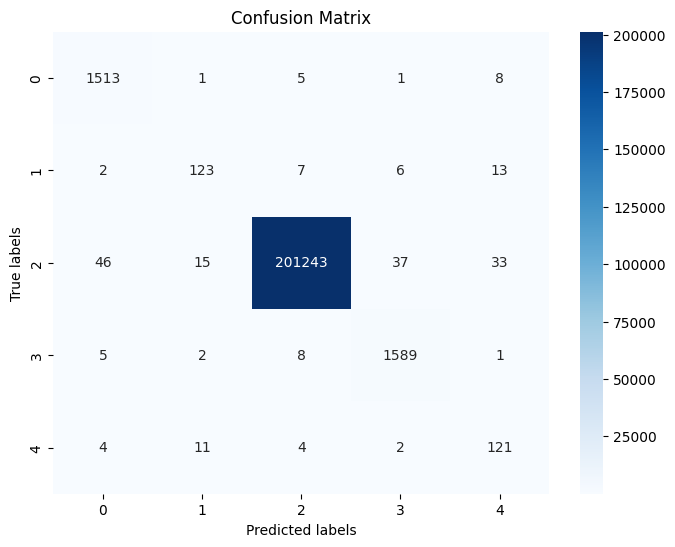

In [ ]:
# création d'un DataLoader pour l'ensemble de données de test
test_dataloader = DataLoader(test_dataset, batch_size=16)

# à tester
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {key: batch[key].to(model.device) for key in batch if key != "labels"}
        labels = batch['labels'].to(model.device)
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        # Convertir indices en labels lisibles
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        true_labels = [list(label_map.keys())[list(label_map.values()).index(l)] for l in labels[0].cpu().numpy()]
        predicted_labels = [list(label_map.keys())[list(label_map.values()).index(p)] for p in predictions[0].cpu().numpy()]
        
        # Afficher les résultats
        print("Tokens:", tokens)
        print("True Labels:", true_labels)
        print("Predicted Labels:", predicted_labels)
        break  # Affichez seulement un exemple
# à tester

f1_score, confusion_mat = calculate_f1_score(model, test_dataloader)

print("F1 Score:", f1_score)
f1_score_percentage = f1_score * 100
print("F1 Score:", f"{f1_score_percentage:.2f}%")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Classification report : à tester

In [15]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, target_names=label_map.keys())
print(report)

NameError: name 'all_labels' is not defined

### Tester le modèle avec 1 phrase

In [16]:
def extract_cities_from_labels(sentence, predicted_labels):
    words = sentence.split()
    departure_city = None
    arrival_city = None
    inside_city = False
    current_city = ""

    for word, label in zip(words, predicted_labels):
        if label == 'B_ville_départ':
            departure_city = word
            inside_city = True
            current_city += word + " "
        elif label == 'I_ville_départ' and inside_city:
            current_city += word + " "
        elif label != 'I_ville_départ' and inside_city:
            inside_city = False
            current_city = current_city.strip()
            if departure_city is None:
                departure_city = current_city
            else:
                arrival_city = current_city
            current_city = ""

    return departure_city, arrival_city

In [34]:
def test_single_sentence(sentence, tokenizer, model, label_map):
    # Tokeniser la phrase avec padding pour l'entrée du modèle
    encoding = tokenizer(sentence, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Afficher les tokens générés par le tokenizer
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    print(f"Tokens: {tokens}")

    # Faire des prédictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2)

    # Afficher les prédictions brutes du modèle
    print(f"Predictions: {predictions[0].cpu().numpy()}")

    # Convertir les prédictions en labels
    predicted_labels = [list(label_map.keys())[list(label_map.values()).index(label_id)] for label_id in predictions[0].cpu().numpy()]
    print(f"Predicted Labels: {predicted_labels}")

    # Identifier les mots correspondant à B_ville_départ et B_ville_arrivée
    departure_city = []
    arrival_city = []
    current_word = []
    current_label = None

    for token, label in zip(tokens, predicted_labels):
        if token == '<pad>':
            continue
        if token.startswith('▁'):
            if current_word:
                word = tokenizer.convert_tokens_to_string(current_word).replace('▁', ' ').strip()
                if current_label == 'B_ville_départ' or current_label == 'I_ville_départ':
                    print("Departure City:", word)
                    departure_city.append(word)
                elif current_label == 'B_ville_arrivée' or current_label == 'I_ville_arrivée':
                    arrival_city.append(word)
                current_word = []
            current_label = label
        current_word.append(token)

    # Ajouter le dernier mot
    if current_word:
        word = tokenizer.convert_tokens_to_string(current_word).replace('▁', ' ').strip()
        if current_label == 'B_ville_départ' or current_label == 'I_ville_départ':
            departure_city.append(word)
        elif current_label == 'B_ville_arrivée' or current_label == 'I_ville_arrivée':
            arrival_city.append(word)

     # Extraire les villes de départ et d'arrivée
    # departure_city, arrival_city = extract_cities_from_labels(sentence, predicted_labels)

    return ' '.join(departure_city), ' '.join(arrival_city)
# departure_city, arrival_city 

In [35]:
sentence = "Je voudrais un billet de Chantillac à Failly."
departure_city, arrival_city = test_single_sentence(sentence, tokenizer, model, label_map)

print(f"Phrase: {sentence}")
print(f"Ville de départ: {departure_city}")
print(f"Ville d'arrivée: {arrival_city}")

Tokens: ['<s>', '▁Je', '▁voudrais', '▁un', '▁billet', '▁de', '▁Chant', 'illac', '▁à', '▁Fa', 'illy', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

In [36]:
def extract_cities_from_labels(sentence, predicted_labels):
    words = sentence.split()
    departure_city = None
    arrival_city = None
    inside_city = False
    current_city = ""

    for word, label in zip(words, predicted_labels):
        if label == 'B_ville_départ':
            departure_city = word
            inside_city = True
            current_city += word + " "
        elif label == 'I_ville_départ' and inside_city:
            current_city += word + " "
        elif label != 'I_ville_départ' and inside_city:
            inside_city = False
            current_city = current_city.strip()
            if departure_city is None:
                departure_city = current_city
            else:
                arrival_city = current_city
            current_city = ""

    return departure_city, arrival_city

# Exemple d'utilisation
sentence = "Je voudrais un billet de Chantillac à Failly."
predicted_labels = ['O', 'O', 'O', 'O', 'O', 'B_ville_départ', 'O', 'B_ville_départ', 'O', 'O', 'O', 'O', 'O', 'O']
departure_city, arrival_city = extract_cities_from_labels(sentence, predicted_labels)

print(f"Phrase: {sentence}")
print(f"Ville de départ: {departure_city}")
print(f"Ville d'arrivée: {arrival_city}")

Phrase: Je voudrais un billet de Chantillac à Failly.
Ville de départ: Failly.
Ville d'arrivée: Chantillac


In [43]:
def test_model_with_sentence(model, tokenizer, sentence, label_map, device='cpu'):
    """    
    Args:
        model: Le modèle de token classification.
        tokenizer: Le tokenizer utilisé pour entraîner le modèle.
        sentence: La phrase à tester.
        label_map: Dictionnaire de mapping entre les labels et leurs indices.
        device: Le périphérique pour exécuter le modèle ('cpu' ou 'cuda').
        
    Returns:
        ville_depart: La ville de départ détectée.
        ville_arrivee: La ville d'arrivée détectée.
    """
    # Étape 1 : Tokenisation
    encoding = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Étape 2 : Prédictions
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2)  # Trouver les classes prédites
    
    # Décoder les prédictions
    predicted_labels = [list(label_map.keys())[label] for label in predictions[0].cpu().numpy()]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    
    print(f"Tokens : {tokens}")
    print(f"Predicted Labels : {predicted_labels}")
    
    # Étape 3 : Reconstruction des villes
    ville_depart, ville_arrivee = [], []
    current_entity = []
    current_label = None

    for token, label in zip(tokens, predicted_labels):
        # Ignorer les tokens spéciaux
        if token in tokenizer.all_special_tokens:
            continue

        if label.startswith('B_ville'):
            # Si une entité est en cours, enregistrer celle-ci avant de commencer une nouvelle
            if current_entity:
                if current_label == 'B_ville_départ':
                    ville_depart.append(tokenizer.convert_tokens_to_string(current_entity))
                elif current_label == 'B_ville_arrivée':
                    ville_arrivee.append(tokenizer.convert_tokens_to_string(current_entity))
            # Début d'une nouvelle entité
            current_entity = [token]
            current_label = label
        elif label.startswith('I_ville') and current_entity:
            # Si c'est un "Inside" d'une entité existante, ajouter le token
            current_entity.append(token)
        else:
            # Si l'entité est terminée, l'enregistrer
            if current_entity:
                if current_label == 'B_ville_départ':
                    ville_depart.append(tokenizer.convert_tokens_to_string(current_entity))
                elif current_label == 'B_ville_arrivée':
                    ville_arrivee.append(tokenizer.convert_tokens_to_string(current_entity))
            current_entity = []
            current_label = None

    # Enregistrer la dernière entité si nécessaire
    if current_entity:
        if current_label == 'B_ville_départ':
            ville_depart.append(tokenizer.convert_tokens_to_string(current_entity))
        elif current_label == 'B_ville_arrivée':
            ville_arrivee.append(tokenizer.convert_tokens_to_string(current_entity))

    # Nettoyer les résultats
    ville_depart = ' '.join(ville_depart).replace('▁', '').strip()
    ville_arrivee = ' '.join(ville_arrivee).replace('▁', '').strip()

    return ville_depart, ville_arrivee

In [44]:
sentence = "Je veux voyager de Gadancourt à Andelot-Morval."
label_map = {'B_ville_arrivée': 0, 'I_ville_départ': 1, 'O': 2, 'B_ville_départ': 3, 'I_ville_arrivée': 4}

ville_depart, ville_arrivee = test_model_with_sentence(model, tokenizer, sentence, label_map)
print(f"Ville de départ : {ville_depart}")
print(f"Ville d'arrivée : {ville_arrivee}")

Tokens : ['<s>', '▁Je', '▁veux', '▁voyager', '▁de', '▁G', 'ad', 'ancourt', '▁à', '▁And', 'e', 'lot', '-', 'Mor', 'val', '.', '</s>']
Predicted Labels : ['O', 'O', 'O', 'O', 'B_ville_départ', 'O', 'B_ville_arrivée', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Ville de départ : de
Ville d'arrivée : ad


In [45]:
def predict_sentence(sentence, model, tokenizer, label_list):
    if isinstance(sentence, str):
        words = sentence.split()
    else:
        words = sentence

    # Tokeniser les mots avec alignement
    tokenized_inputs = tokenizer(words, truncation=True, padding="max_length", max_length=128, is_split_into_words=True, return_tensors="pt")
    word_ids = tokenized_inputs.word_ids()  # Alignement des mots

    # Déplacer les tensors d'entrée vers le même périphérique que le modèle
    tokenized_inputs = {key: tensor.to(model.device) for key, tensor in tokenized_inputs.items()}

    # Passer les données dans le modèle
    with torch.no_grad():
        output = model(**tokenized_inputs)

    # Prédictions et extraction des labels
    predictions = output.logits.argmax(dim=-1).squeeze().cpu().tolist()
    tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"].squeeze().cpu().tolist())

    # Fusionner les sous-tokens
    result = []
    current_word = ""
    current_label = None
    for token, label_id, word_id in zip(tokens, predictions, word_ids):
        if token == "<pad>" or word_id is None:
            continue

        label = label_list[label_id]
        if token.startswith("▁"):
            if current_word:
                result.append((current_word, current_label))
            current_word = token[1:]
            current_label = label
        else:
            current_word += token

    if current_word:
        result.append((current_word, current_label))

    return result

In [46]:
sentence = "Je veux voyager de Gadancourt à Andelot-Morval."
label_list = ['B_ville_arrivée', 'I_ville_départ', 'O', 'B_ville_départ', 'I_ville_arrivée']
result = predict_sentence(sentence, model, tokenizer, label_list)
print(result)

[('Je', 'O'), ('veux', 'O'), ('voyager', 'O'), ('de', 'B_ville_départ'), ('Gadancourt', 'O'), ('à', 'O'), ('Andelot-Morval.', 'O')]
